In [1]:
import pandas as pd

from pandas import DataFrame as df
import numpy as np
import csv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity 
import pickle
import keras
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Embedding, Reshape, Dot
from keras.models import Model 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import stats

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [273]:
phy_dists = pd.read_csv("data/silva/tree/phy_dists.txt", sep = " ", index_col=0)

dict_file = open("dictionary.obj", "rb")
dictionary = pickle.load(dict_file)

revdict_file = open("reverse_dictionary.obj", "rb")
reverse_dictionary = pickle.load(revdict_file)

vocab_size = len(dictionary)
#Dictionary goes [taxa: int_id]
#Reverse dictionary goes [int_id: taxa]

def getPhyDist(id_1, id_2):
    return(phy_dists[id_1][id_2])

KeyboardInterrupt: 

In [3]:
qual_vecs = pd.read_csv("embeddings/silva/glove_emb_freshwater_2perc_500.txt", sep = " ", index_col = 0, header=None)
qual_vecs = qual_vecs.drop("<unk>", axis = 0)
qual_vecs.head()

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,,,,,,,,,,,,,,,,,,,,,
EF111171,0.120558,0.344913,0.065359,0.164604,0.022335,-0.010506,0.215318,-0.398671,-0.055348,0.090604,...,0.135781,-0.064413,-0.034190,-0.122950,0.247035,-0.092621,-0.236262,-0.082161,-0.089951,0.004798
GU127198,0.052221,0.552655,0.006732,0.067078,0.247296,0.365529,-0.070627,-0.283178,-0.079033,0.300026,...,-0.120189,0.061027,-0.304076,0.269277,0.053615,0.089568,-0.205022,-0.240862,-0.037295,0.188797
GQ388775,-0.281597,0.364923,-0.083480,-0.009604,-0.127312,-0.192143,0.219929,0.042317,-0.167354,0.328284,...,0.075366,0.267785,0.011325,-0.047053,0.108474,-0.132507,-0.389616,0.124557,-0.119673,-0.125174
HM346776,-0.097267,0.125345,-0.163497,0.419889,-0.099444,0.082789,0.227000,0.057113,-0.282058,0.001284,...,-0.061076,0.018308,-0.165371,0.014313,-0.035307,0.093557,-0.552330,0.219922,-0.146428,0.281244
EU800295,0.232074,0.197474,-0.131251,0.240901,0.219368,0.400498,0.257570,-0.104864,-0.204351,-0.068343,...,-0.037122,-0.236228,-0.252097,0.026793,0.052869,-0.040219,-0.123651,0.148660,0.188558,0.477138


In [4]:
#Sort quality vector by taxa name
qual_vecs_sort = qual_vecs.reindex(sorted(qual_vecs.index))
qual_vecs_sort.head()
qual_vecs = qual_vecs_sort

In [5]:
#Sort phylogenetic distances by taxa name
phy_dists_sort = phy_dists.reindex(sorted(phy_dists.columns), axis = 1)
phy_dists_sort = phy_dists_sort.reindex(sorted(phy_dists.columns), axis = 0)
phy_dists = phy_dists_sort
phy_dists.head()

,AAAA02048336,AACY020061762,AACY020170993,AACY020414384,AACY020539760,AACY023242300,AACY023337690,AACY023514927,AAQJ02000001,AB003934,...,Z49728,Z49729,Z49733,Z49735,Z76663,Z95718,Z95727,Z95729,Z95732,Z96085
AAAA02048336,0.00000,0.97377,0.97904,1.16393,1.20581,1.11508,1.06410,1.10324,1.12875,0.83245,...,0.98828,1.01032,0.98464,1.06954,1.13430,0.97459,0.97422,0.96157,0.97635,1.10995
AACY020061762,0.97377,0.00000,0.56873,1.17384,0.64720,1.12499,0.53903,0.63907,0.48432,0.61458,...,0.34385,0.36589,0.34021,0.42511,0.46343,0.60020,0.56391,0.55126,0.56604,0.42622
AACY020170993,0.97904,0.56873,0.00000,1.17911,0.80077,1.13026,0.65906,0.69820,0.72371,0.61985,...,0.58324,0.60528,0.57960,0.66450,0.72926,0.60547,0.54618,0.53353,0.54831,0.70491
AACY020414384,1.16393,1.17384,1.17911,0.00000,1.40588,0.18569,1.26417,1.30331,1.32882,1.03252,...,1.18835,1.21039,1.18471,1.26961,1.33437,1.17466,1.17429,1.16164,1.17642,1.31002
AACY020539760,1.20581,0.64720,0.80077,1.40588,0.00000,1.35703,0.77107,0.87111,0.80218,0.84662,...,0.66171,0.68375,0.65807,0.74297,0.80773,0.83224,0.79595,0.78330,0.79808,0.78338


In [6]:
#Calculate distances between taxa using metric = cosine dissimilarity between quality vectors
from sklearn.metrics import pairwise_distances
qual_vec_dists = pairwise_distances(qual_vecs, metric="cosine")
taxa = qual_vecs.index.values
qual_vec_dists = pd.DataFrame(qual_vec_dists, index = taxa, columns = taxa)

In [7]:
#Only keep phylogenetic distances between taxa that we have quality vector distances for
keep = [phy_dists.index.values[i] in taxa for i in range(phy_dists.shape[0])]
phy_dists = phy_dists.loc[keep, taxa]

In [8]:
#Pick 1000 random rows
rand_row = np.random.choice(range(phy_dists.shape[0]), 10000)
phy_dists_small = phy_dists.iloc[rand_row, :]
qual_dists_small = qual_vec_dists.iloc[rand_row, :]
taxa = phy_dists_small.index.values

In [9]:
#Turn matrices into vectors
phy_dists_vec = np.array([i for sublist in np.array(phy_dists_small) for i in sublist])
qual_dists_vec = np.array([i for sublist in np.array(qual_dists_small) for i in sublist])
taxa_pairs = np.array([(i, j) for i in phy_dists_small.index.values for j in phy_dists_small.columns.values])

100


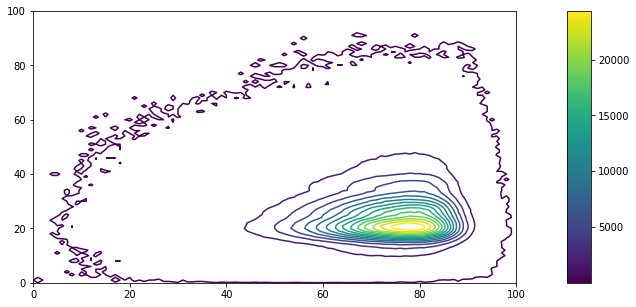

In [272]:
import matplotlib as mpl
def plotLegend(scale, ax, cmap):
    norm = mpl.colors.Normalize(vmin=min(scale), vmax=max(scale))
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm = norm,
                                    orientation='vertical')

def plotCorrelationContour(dists_vecx, dists_vecy):
    from collections import Counter
    end_range = 10000000
    x = dists_vecx[0:end_range]
    y = dists_vecy[0:end_range]
    bins_x = np.linspace(0, np.max(x), 100)
    bins_y = np.linspace(0, np.max(y), 100)
    x_inds = np.digitize(x, bins_x)
    y_inds = np.digitize(y, bins_y)

    #Count number of times we saw that phy_dist and that qual_dist corresponding
    pairs = zip(x_inds, y_inds)
    pairs_list = [(i,j) for (i,j) in pairs]
    count = Counter(pairs_list)
    
    z = np.zeros((len(bins), len(bins)))
    for i in range(len(bins_x)):
        for j in range(len(bins_y)):
            z[j, i] = count[(j, i)]
            
    max_val = np.max(z)
    scale = np.arange(1, max_val, max_val / 15)
    cmap = 'viridis'
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5), gridspec_kw = {'width_ratios':[20, 1]})
    ax1.contour(z, levels = scale, cmap =  cmap)
    print(np.max(y_inds))
    ax1.set_ylim(0, np.max(y_inds))
    ax1.set_xlim(0, np.max(x_inds))
    plotLegend(scale, ax2, cmap)

plotCorrelationContour(phy_dists_vec, qual_dists_vec)

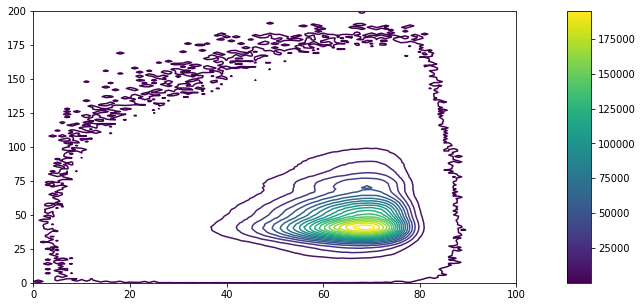

Pearson Coefficient: 0.040946800105165874
Pearson P-value: 0.0


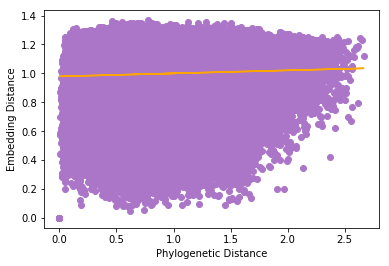

In [10]:
#Plot the relationship between phylogenetic distances and embedding distances

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
plt.plot(x,y,'o', color = "#AC76C8")
plt.plot(x, line, color = "orange")
plt.xlabel("Phylogenetic Distance")
plt.ylabel("Embedding Distance")

#Correlation
corr = pearsonr(x,y)
print("Pearson Coefficient: " + str(corr[0]))
print("Pearson P-value: " + str(corr[1]))

In [ ]:
qual_dists_vec_neg = 0 - qual_dists_vec
add = qual_dists_vec_neg + phy_dists_vec
sort_ind = np.argsort(add)

In [ ]:
numFeatures = 1500
i = 0
taxa_pairs_keep = []
taxa_keep = set()
numFeaturesSelected = 0
while numFeaturesSelected < numFeatures:
    pair = taxa_pairs[sort_ind[i]]
    taxa_keep.add(pair[0])
    taxa_keep.add(pair[1])
    numFeaturesSelected = len(taxa_keep)
    i = i + 1
    
print("Number of taxa: " + str(len(taxa_keep)))

10000

In [151]:

file = open("feature_selection/taxa_lowphy_highcos.obj", "wb")
pickle.dump(taxa_keep, file)
file.close()

Old code + graphing utility

In [13]:
slope = 1.1
intercept = 0.8
y = [slope * i + intercept for i in phy]



In [65]:
keep = [cosine[i] > y[i] for i in range(len(phy))]

taxa_keep = set()
for pair in np.array(taxa_pairs)[keep]:
    taxa_keep.add(pair[0])
    taxa_keep.add(pair[1])
print("Number of taxa: " + str(len(taxa_keep)))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 11132000 but corresponding boolean dimension is 89251

In [11]:
file = open("taxa_lowphy_highcos.obj", "wb")
pickle.dump(taxa_keep, file)
file.close()

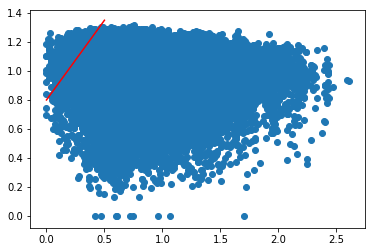

In [15]:
plt.scatter(phy[0:100000], cosine[0:100000])
x = [i * .1 for i in range(6)]
plt.plot(x,[slope * i + intercept for i in x] , color = "red")

[1.33526327 1.32580517 1.29521601 1.27690225 1.27355639 1.27327988
 1.30040277 1.32775647 1.25672926 1.25671563]
[0.      0.03006 0.      0.      0.      0.      0.03478 0.06482 0.
 0.     ]


In [73]:
print(taxa_pairs_keep[0][0])
print(taxa_pairs_keep[0][1])
print(phy_dists[taxa_pairs_keep[0][0]][taxa_pairs_keep[0][1]])
qual_vec_dists_pd[taxa_pairs_keep[0][0]][taxa_pairs_keep[0][1]]
qual_vec_dists_pd[taxa_pairs_keep[1][0]][taxa_pairs_keep[1][1]]
qual_vec_dists_pd[taxa_pairs_keep[3][0]][taxa_pairs_keep[3][1]]

JX489958
FJ437855
1.06155


1.2769022495518947